## Import libaries

In [ ]:
# !pip uninstall dea_ml -y

In [ ]:
!pip install -e dea_ml
!pip install git+https://github.com/digitalearthafrica/deafrica-sandbox-notebooks.git@minty-fresh-sandbox#subdirectory=Tools

In [1]:
import os
import json
import xarray as xr
import geopandas as gpd
from odc.stats.tasks import TaskReader
from odc.stats.model import OutputProduct

/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Enter the (old) X and Y Tile ID of the tile you want to run

In [2]:
tile_x = '+0031'  #+0031,+0003
tile_y = '+0003'

### Open tiles geojson and find the new tile-id for the location entered 

In [4]:
tiles=gpd.read_file('https://github.com/digitalearthafrica/crop-mask/blob/main/testing/eastern_cropmask/data/gm_s2_2019-2019--P1Y.geojson?raw=true')
t=[]
for index, row in tiles.iterrows():
    x,y = tiles.loc[index]['title'].split(",")
    if (x==tile_x) & (y==tile_y): 
        x,y = int(x)+181, int(y)+77
        new_title = str(x)+","+str(y)
        t.append(x)
        t.append(y)
        print(new_title)

212,80


### Extract the tasks object for that tile

In [5]:
name, version = 'gm_s2_semiannual', '0-1-0'
op = OutputProduct(
            name='gm_s2_semiannual',
            version='0-1-0',
            short_name='gm_s2_semiannual',
            location=f"s3://dummy-bucket/{name}/{version}",
            properties={"odc:file_format": "GeoTIFF"},
            measurements=['red'],
        )

taskdb = TaskReader('s3://deafrica-data-dev-af/crop_mask_eastern/0-1-0/gm_s2_semiannual_all.db', product=op)
task = taskdb.load_task(('2019--P1Y', t[0], t[1]))

### Optionally export tile geojson to view

In [6]:
with open('task_tile_check.geojson', 'w') as fh:
    json.dump(task.geobox.extent.to_crs('epsg:4326').json, fh, indent=2)

### Find the index of the tile we want to run

In [7]:
tile_index_to_run = []
all_tiles = list(taskdb.all_tiles)
for i, index in zip(all_tiles, range(0, len(all_tiles))):
    if (i[1]==t[0]) & (i[2]==t[1]):
        tile_index_to_run.append(index)
        print(index)

3100


### Run the crop-mask algo using odc-stats

In [12]:
os.system("cm-pred run "\
          "s3://deafrica-data-dev-af/crop_mask_eastern/0-1-0/gm_s2_semiannual_all.db "\
          "--config=https://raw.githubusercontent.com/digitalearthafrica/crop-mask/feature/use-config-for-all-urls/production/dea_ml/dea_ml/config/plugin_product.yaml "\
          "--plugin-config=https://raw.githubusercontent.com/digitalearthafrica/crop-mask/feature/use-config-for-all-urls/production/dea_ml/dea_ml/config/ml_config.yaml "\
          "--resolution=40 "\
          "--threads=10 "\
          "--memory-limit=90Gi "\
          "--location=file:///home/jovyan/git/crop-mask/production/{product}/{version} "+str(tile_index_to_run[0])
         )

0

### Or can run with cmd line, will see print statements

In [ ]:
# !cm-pred run s3://deafrica-data-dev-af/crop_mask_eastern/0-1-0/gm_s2_semiannual_all.db --config=https://raw.githubusercontent.com/digitalearthafrica/crop-mask/feature/use-config-for-all-urls/production/dea_ml/dea_ml/config/plugin_product.yaml  --plugin-config=https://raw.githubusercontent.com/digitalearthafrica/crop-mask/feature/use-config-for-all-urls/production/dea_ml/dea_ml/config/ml_config.yaml  --resolution=40 --threads=10 --memory-limit=80Gi --location=file:///home/jovyan/git/crop-mask/production/{product}/{version} 3100

## Plot the results

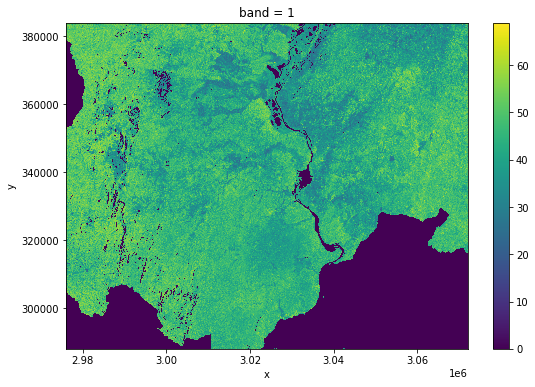

In [13]:
a= 'x'+str(t[0])
b='y0'+str(t[1])
xr.open_rasterio('crop_mask_eastern/0-1-0/'+a+'/'+b+'/2019--P1Y/crop_mask_eastern_'+a+b+'_2019--P1Y_prob.tif').squeeze().plot.imshow(size=6);

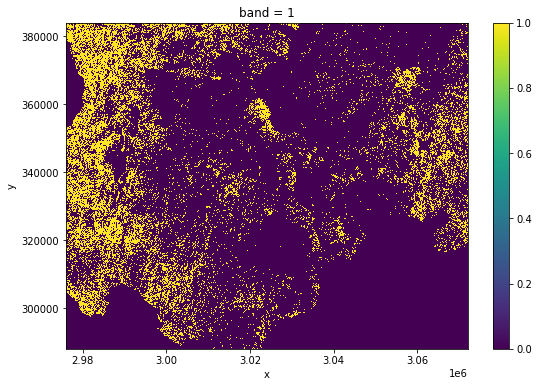

In [14]:
xr.open_rasterio('crop_mask_eastern/0-1-0/'+a+'/'+b+'/2019--P1Y/crop_mask_eastern_'+a+b+'_2019--P1Y_mask.tif').squeeze().plot.imshow(size=6);

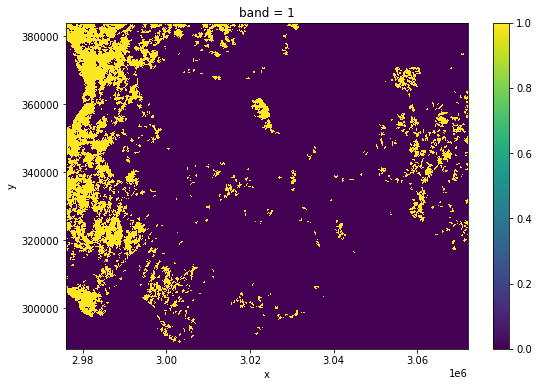

In [15]:
xr.open_rasterio('crop_mask_eastern/0-1-0/'+a+'/'+b+'/2019--P1Y/crop_mask_eastern_'+a+b+'_2019--P1Y_filtered.tif').squeeze().plot.imshow(size=6);

### Remove all files

In [16]:
!rm -r -f crop_mask_eastern